In [2]:
%pip install lifelines

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.9/432.9 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 26.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4119 sha256=97bcdd59c86d0bc86818e00a8fa5043a20c7b7f1ef42d6741285ce7ff6c0c7b1
  Stored in directory: /nfs/home/medoro/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the ker

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
def download_dataset(url):
    d = pd.read_csv(url) # POTENTIALLY: apply parse_dates, based on the dataset format
    ids = d.id
    d.drop(['id'], axis = 1, inplace = True)
    print(d.info(show_counts = True))
    return d, ids

In [33]:
train, _ = download_dataset("train.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB
None


In [36]:
def categorical_handling(categories, names, df):
    for c, n in zip(categories, names):
        ohe = LabelEncoder() #OneHotEncoder(sparse_output = False)
        encs = ohe.fit_transform(df[[c]])
        encs_df = pd.DataFrame(encs)
        n_col = len(encs_df.columns)
        cols = []
        for nn in range(0, n_col):
            cols.append(""+n+""+str(nn))
        encs_df.columns = cols
        df = pd.concat([df, encs_df], axis = 1)
        df.drop(c, axis = 1, inplace = True)
    return df

In [37]:
catv = ['Geography', 'Gender'] #, 'IsActiveMember', 'HasCrCard', 'NumOfProducts']
names = ['Geo', 'Gen'] #, 'Act', 'Cred', 'Prod']
train = categorical_handling(catv, names, train)

/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
set_config(display="Text")

In [39]:
train.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

In [40]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo0,Gen0
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,2,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2,0


In [41]:
non_ob_trian = train.select_dtypes(exclude = 'object')

In [42]:
non_ob_trian

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo0,Gen0
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,2,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2,0


In [43]:
cph = CoxPHFitter()
cph.fit(non_ob_trian, 'Tenure', 'Exited')

<lifelines.CoxPHFitter: fitted with 165034 total observations, 130113 right-censored observations>

In [44]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 165034 total observations, 130113 right-censored observations>
             duration col = 'Tenure'
                event col = 'Exited'
      baseline estimation = breslow
   number of observations = 165034
number of events observed = 34921
   partial log-likelihood = -376865.15
         time fit was run = 2026-01-08 14:23:54 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
CreditScore     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Age              0.06      1.06      0.00            0.06            0.06                1.06                1.06
Balance          0.00      1.00      0.00            0.00            0.00                1.00                1.00
NumOfProducts   -0.60      0.55      0.01           -0.62           -0.57                0.54                0.56
HasCrCard       -0.09      0.91      0.01           -0.11           -0.07                0.89                0.94
IsActiveMember  -0.89      0.41      0.01           -0.91           -0.86                0.40                0.42
EstimatedSalary  0.00      1.00      0.00            0.00            0.00                1.00                1.00
Geo0             0.08      1.08      0.01            0.06            0.09                1.06                1.09
Gen0            -0.46      0.63      0.01           -0.48           -0.44                0.62                0.65

                 cmp to      z      p  -log2(p)
covariate                                      
CreditScore        0.00  -6.53 <0.005     33.82
Age                0.00 117.31 <0.005       inf
Balance            0.00  16.52 <0.005    201.24
NumOfProducts      0.00 -51.91 <0.005       inf
HasCrCard          0.00  -7.49 <0.005     43.78
IsActiveMember     0.00 -74.84 <0.005       inf
EstimatedSalary    0.00   6.56 <0.005     34.12
Geo0               0.00  11.34 <0.005     96.55
Gen0               0.00 -41.93 <0.005       inf
---
Concordance = 0.75
Partial AIC = 753748.29
log-likelihood ratio test = 27715.11 on 9 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

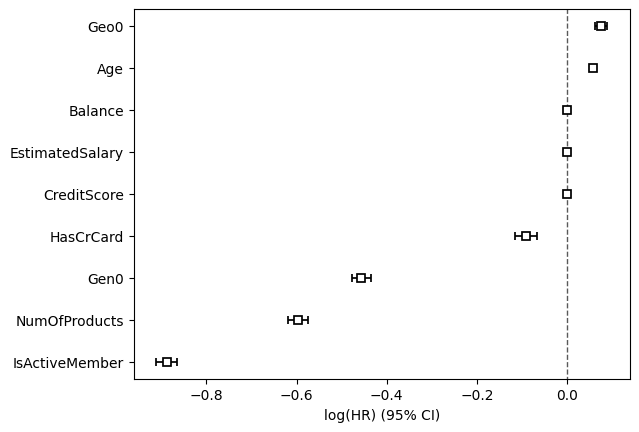

In [45]:
cph.plot()

In [46]:
cph.predict_median(non_ob_trian)

0         inf
1         inf
2         inf
3         inf
4         inf
         ... 
165029    inf
165030    inf
165031    inf
165032    inf
165033    inf
Name: 0.5, Length: 165034, dtype: float64

In [47]:
cph.predict_survival_function(non_ob_trian)

,0,1,2,3,4,5,6,7,8,9,...,165024,165025,165026,165027,165028,165029,165030,165031,165032,165033
0.0,0.996616,0.998706,0.994927,0.996754,0.998585,0.990403,0.990651,0.989557,0.994129,0.995237,...,0.997117,0.997044,0.987667,0.989910,0.996627,0.995514,0.993093,0.997733,0.994722,0.995357
1.0,0.986299,0.994742,0.979510,0.986856,0.994253,0.961508,0.962488,0.958170,0.976320,0.980754,...,0.988319,0.988022,0.950743,0.959563,0.986343,0.981867,0.972183,0.990806,0.978692,0.981235
2.0,0.975655,0.990626,0.963689,0.976638,0.989755,0.932276,0.933975,0.926502,0.958089,0.965877,...,0.979227,0.978701,0.913710,0.928909,0.975733,0.967836,0.950849,0.983635,0.962251,0.966723
3.0,0.962690,0.985575,0.944534,0.964187,0.984238,0.897456,0.899981,0.888895,0.936080,0.947845,...,0.968132,0.967331,0.870031,0.892460,0.962808,0.950812,0.925189,0.974864,0.942361,0.949126
4.0,0.947260,0.979509,0.921907,0.949360,0.977616,0.857132,0.860569,0.845504,0.910171,0.926515,...,0.954900,0.953774,0.820053,0.850340,0.947426,0.930650,0.895119,0.964375,0.918887,0.928300
5.0,0.929908,0.972613,0.896680,0.932673,0.970093,0.813207,0.817584,0.798445,0.881402,0.902696,...,0.939980,0.938494,0.766376,0.804576,0.930125,0.908104,0.861908,0.952511,0.892741,0.905029
6.0,0.912419,0.965582,0.871491,0.915842,0.962428,0.770441,0.775675,0.752843,0.852805,0.878872,...,0.924902,0.923058,0.714907,0.760142,0.912688,0.885518,0.829085,0.940480,0.866666,0.881739
7.0,0.889254,0.956140,0.838498,0.893529,0.952142,0.716079,0.722315,0.695202,0.815546,0.847603,...,0.904863,0.902554,0.650663,0.703845,0.889590,0.855820,0.786611,0.924426,0.832558,0.851145
8.0,0.856096,0.942357,0.792018,0.861548,0.937143,0.642693,0.650113,0.618006,0.763447,0.803423,...,0.876044,0.873086,0.566146,0.628198,0.856524,0.813749,0.727799,0.901203,0.784599,0.807870
9.0,0.799699,0.918134,0.715024,0.807037,0.910836,0.529412,0.538227,0.500406,0.678212,0.729882,...,0.826643,0.822630,0.441126,0.512320,0.800275,0.743416,0.633125,0.861010,0.705408,0.735702


In [48]:
survival_function = cph.predict_survival_function(non_ob_trian)
predicted_time_to_churn = survival_function[survival_function <= 0.5]

In [49]:
predicted_time_to_churn

,0,1,2,3,4,5,6,7,8,9,...,165024,165025,165026,165027,165028,165029,165030,165031,165032,165033
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.441126,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
churns = predicted_time_to_churn.apply(lambda col: col.first_valid_index())

<Axes: >

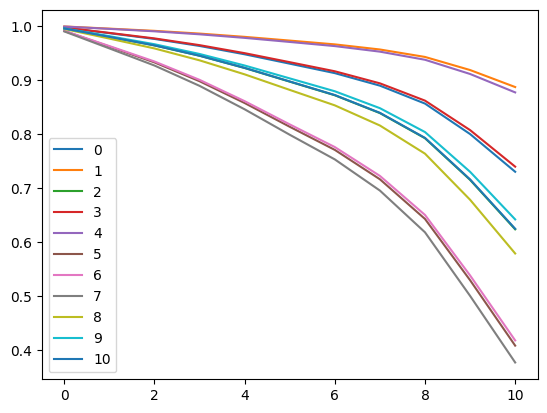

In [51]:
cph.predict_survival_function(non_ob_trian).loc[:, :10].plot()

In [52]:
cph.predict_log_partial_hazard(non_ob_trian)

0        -0.432283
1        -1.394298
2        -0.026341
3        -0.474005
4        -1.304970
            ...   
165029   -0.149737
165030    0.283090
165031   -0.833488
165032    0.013228
165033   -0.115161
Length: 165034, dtype: float64

In [53]:
cph.predict_partial_hazard(non_ob_trian)

0         0.649026
1         0.248007
2         0.974002
3         0.622504
4         0.271181
            ...   
165029    0.860934
165030    1.327225
165031    0.434531
165032    1.013316
165033    0.891222
Length: 165034, dtype: float64

In [54]:
cph.baseline_hazard_

,baseline hazard
0.0,0.005222
1.0,0.016033
2.0,0.016718
3.0,0.020612
4.0,0.024895
5.0,0.028487
6.0,0.029254
7.0,0.039623
8.0,0.058550
9.0,0.104999


In [55]:
cph.baseline_survival_

,baseline survival
0.0,0.994791
1.0,0.978969
2.0,0.962738
3.0,0.943097
4.0,0.919909
5.0,0.894073
6.0,0.868297
7.0,0.834565
8.0,0.787104
9.0,0.708650


<Axes: >

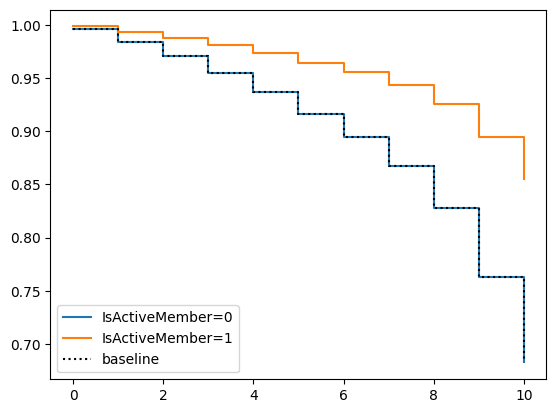

In [56]:
cph.plot_partial_effects_on_outcome(covariates='IsActiveMember', values = [0, 1])

In [57]:
cph.score(non_ob_trian)

np.float64(-2.2835606363826577)